January: Part 5 - This notebook is a continuation of gyre_runs_mackenzie03.ipynb. The configuration used to produce these results is still gyre_mackenzie02. 

Recent changes:
* Reorganizing directories and files
* Testing the NEMO Command
* Doubling the previous resolution - 2.24 km

In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/mackenzie_canyon/tools/')
import functions_plot

from salishsea_tools import nc_tools, viz_tools
from salishsea_tools import gsw_calls

In [2]:
bathyI_file = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/NEMO_files/idealized/ideal_bathy_04.nc')
bathyI = bathyI_file['Bathymetry']
bathyR_file = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/NEMO_files/realistic/real_bathy_02.nc')
bathyR = bathyR_file['Bathymetry']
coord_lats = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/coordinates/NEMO_files/coords_02.nc')['nav_lat'][:]

In [3]:
pathI = '/ocean/imachuca/Canyons/results_mackenzie/idealized/Resolution_237_177/'
pathR = '/ocean/imachuca/Canyons/results_mackenzie/realistic/Resolution_237_177/'
cfg = 'Run01'
gridI1, lonI1, latI1, temI1, salI1, sshI1, UI1, VI1, WI1, tmaskI1 = functions_plot.load_model_output(pathI, cfg)
gridR1, lonR1, latR1, temR1, salR1, sshR1, UR1, VR1, WR1, tmaskR1 = functions_plot.load_model_output(pathR, cfg)
depth_levels = gridI1['deptht'][:]

In [4]:
def plot_quiver_stories(U_vel, V_vel, gridT, depth_inds, time_inds, arrow, bathy_file):
    fig, ax = plt.subplots(len(time_inds), len(depth_inds), figsize=(18, 30), sharex=True, sharey=True)
    fig.tight_layout()
    for dep, i in zip(depth_inds, np.arange(len(depth_inds))):
        for time_ind, n in zip(time_inds, np.arange(len(time_inds))):
            ugrid = U_vel[time_ind, dep, :, :]
            vgrid = V_vel[time_ind, dep, :, :]
            u_nstg0 = (np.add(ugrid[..., :-1], ugrid[..., 1:]) / 2)[..., 1:, :]
            v_nstg0 = (np.add(vgrid[..., :-1, :], vgrid[..., 1:, :]) / 2)[..., 1:]
            u_nstg = u_nstg0[::arrow,::arrow]
            v_nstg = v_nstg0[::arrow,::arrow]
            x_slice = np.arange(1, ugrid.shape[1])[::arrow]
            y_slice = np.arange(1, ugrid.shape[0])[::arrow]
            speeds = np.sqrt(u_nstg**2 + v_nstg**2)

            q = ax[n, i].quiver(x_slice, y_slice, u_nstg, v_nstg, speeds, clim=[0,0.3],
                          pivot='tip', cmap='Spectral_r', width=0.005, headwidth=2.5)
            ax[n, i].set_ylim(0, y_slice[-1])
            ax[n, i].set_xlim(0, x_slice[-1])
            timestamp = nc_tools.timestamp(gridT,time_ind).format('MMM DD HH:mm')
            ax[n,i].set_yticklabels([])
            dep_m = round(gridT['deptht'][:][dep],2)
            if i == 0:
                ax[n, i].set_ylabel(timestamp, fontsize=16)
                fig.colorbar(q, ax=ax[n, i])
            if n == 0:
                ax[n,i].set_title('depth : '+str(dep_m)+' m', fontsize=16)
            #ax[n,i].contour(bathy, levels = [dep_m], colors='k', linewidths=2, alpha=0.5)
            viz_tools.plot_land_mask(ax[n,i],bathy_file,'grid', dep_m, None, None, 'wheat')
    return fig

# Horizontal flow at various depths

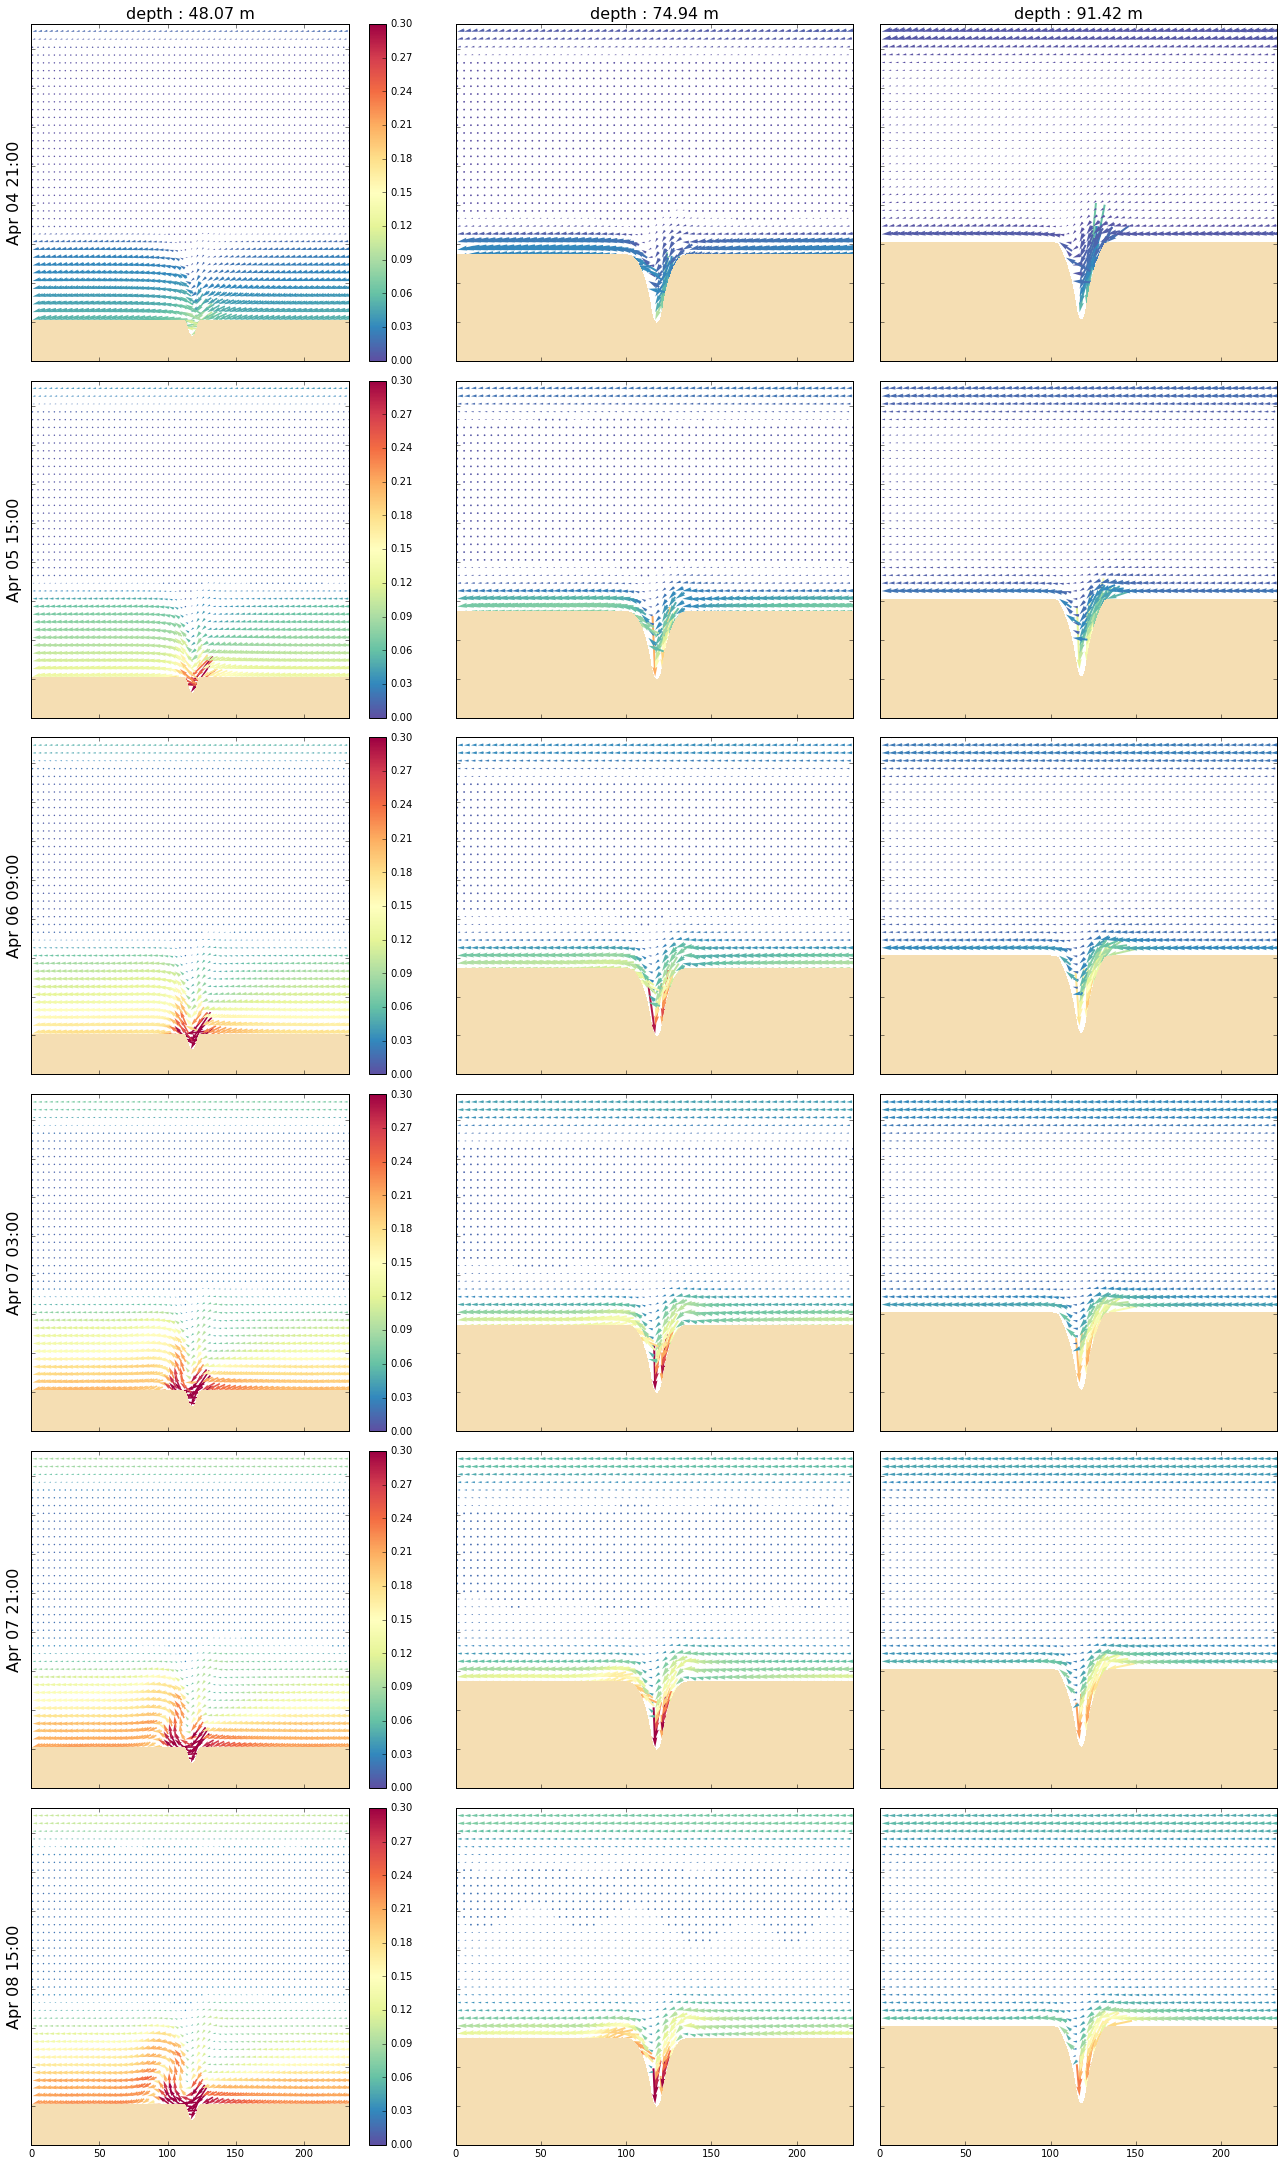

In [5]:
depth_inds = [4, 6, 7]
time_inds = [3, 6, 9, 12, 15, 18]
fig = plot_quiver_stories(UI1, VI1, gridI1, depth_inds, time_inds, 4, bathyI_file)

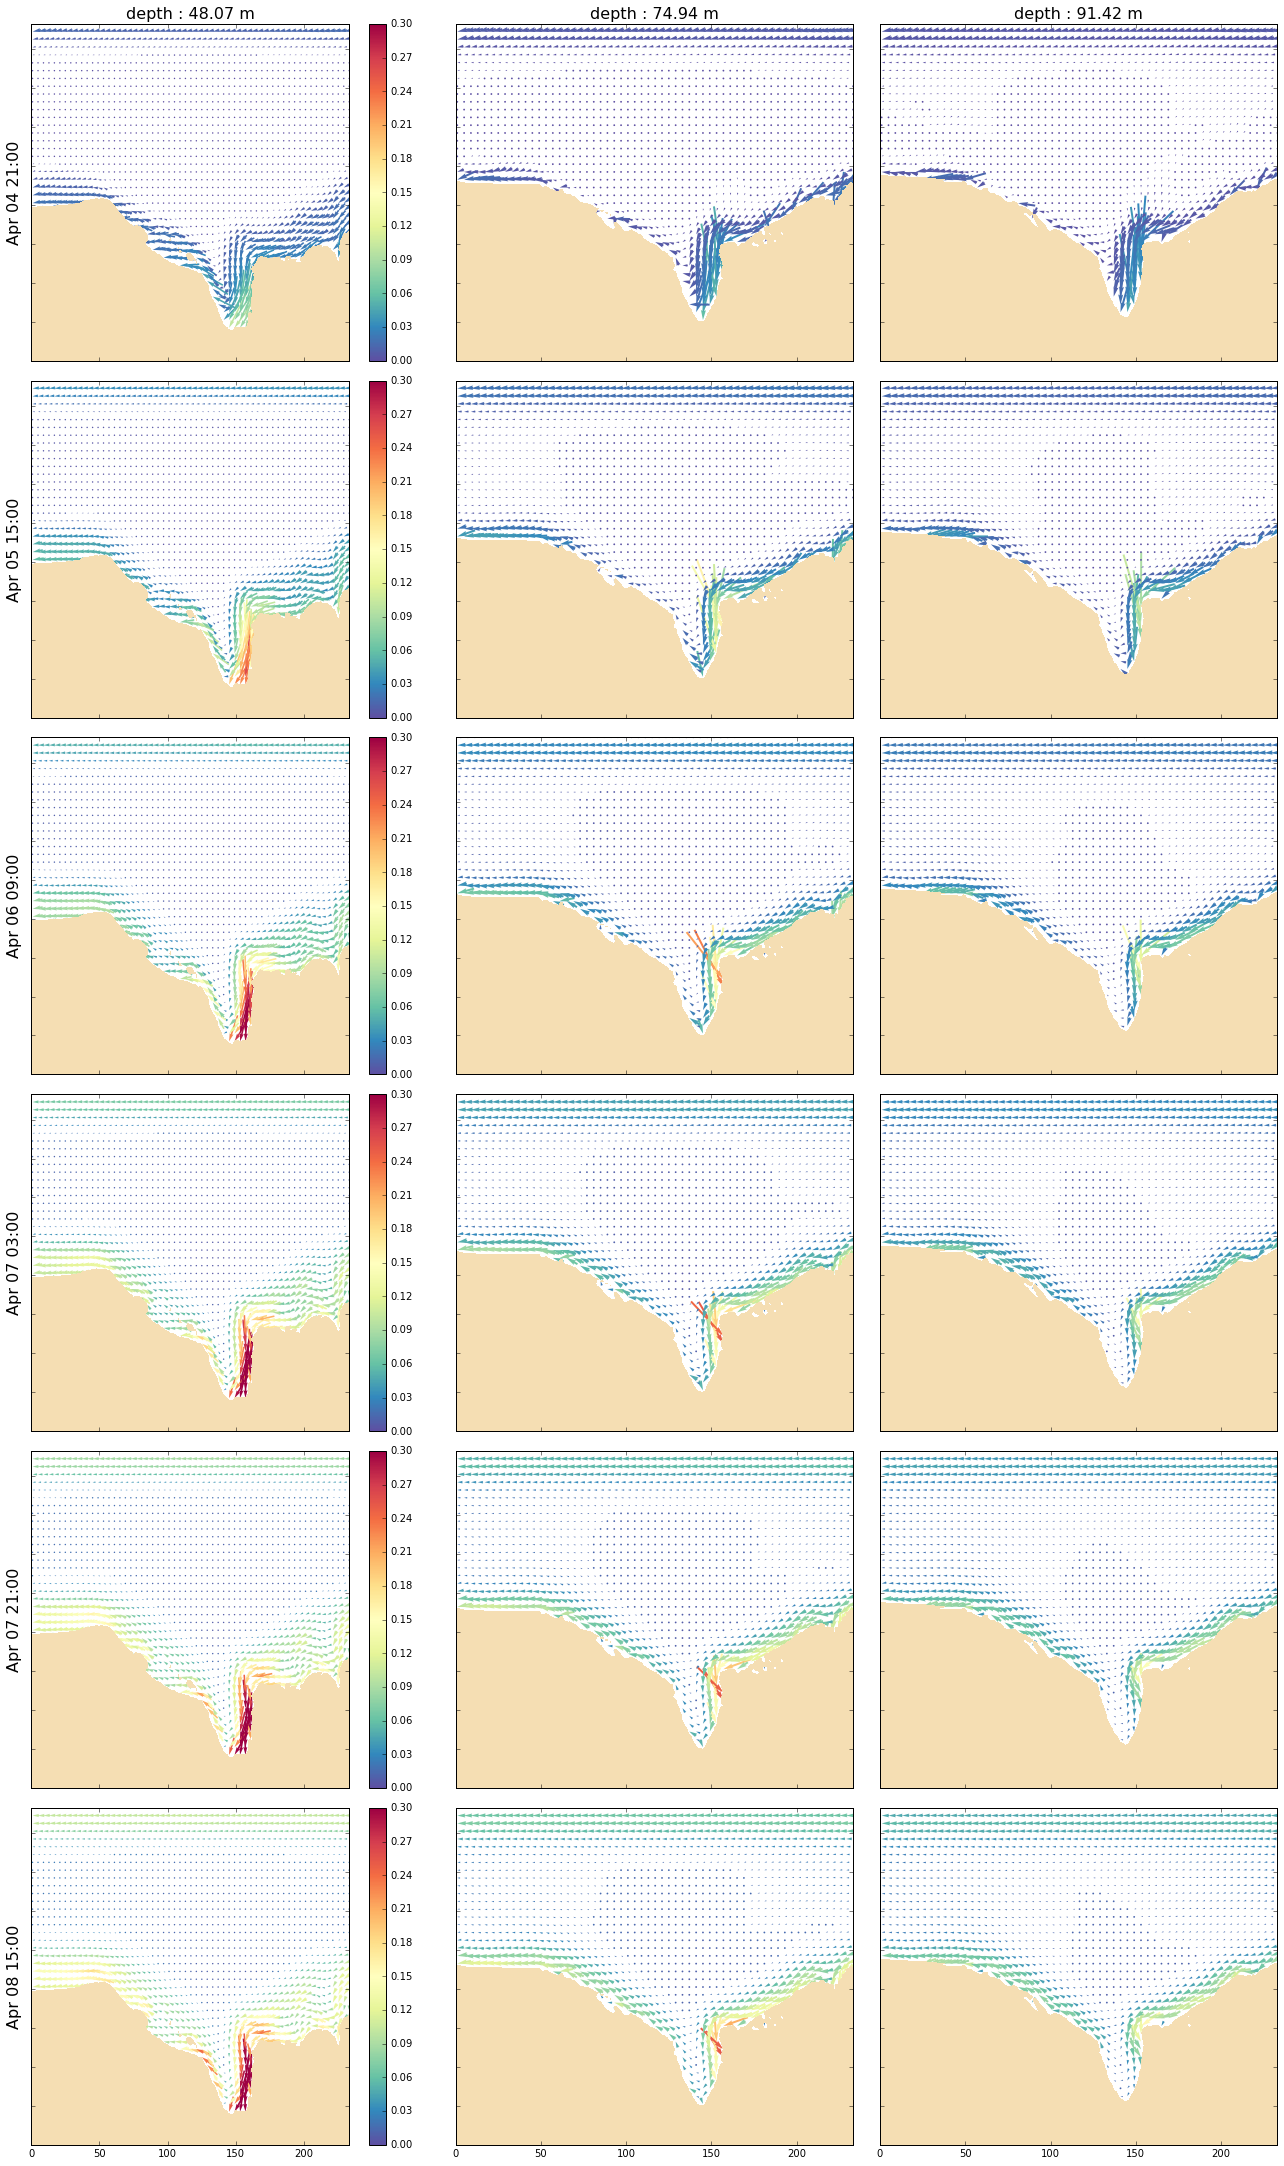

In [6]:
depth_inds = [4, 6, 7]
time_inds = [3, 6, 9, 12, 15, 18]
fig = plot_quiver_stories(UR1, VR1, gridR1, depth_inds, time_inds, 4, bathyR_file)

    How I visualize unstaggering (simplified):
    ugrid = U[t, :, y, :] = [d, x] = 20 x 237
    wgrid = W[t, :, y, :] = [d, x] = 20 x 237
    
    uavg = ugrid[d, :-1], ugrid[d, 1:] = 20 x 236
    wavg = wgrid[:-1, x], wgrid[1:, x] = 19 x 237
    
    us = uavg[1:, :] = 19 x 236
    ws = wavg[:, 1:] = 19 x 236

(366.56561728437669, 305.34507306892414)

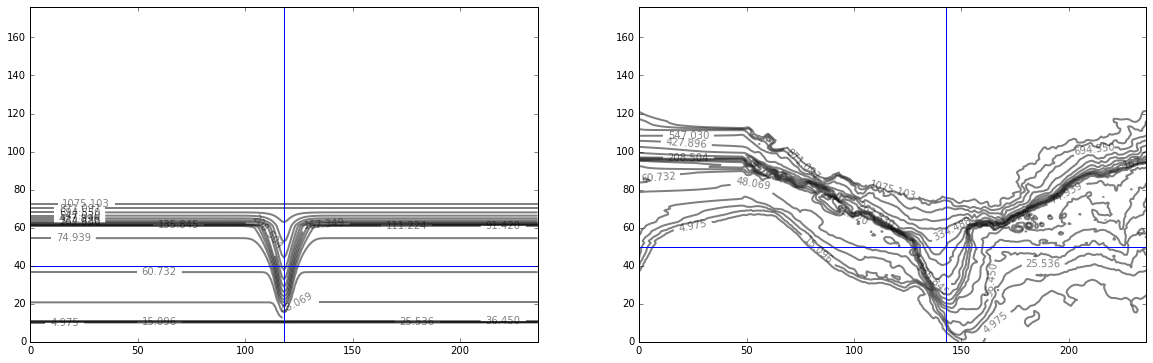

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
levels = depth_levels.tolist()
c1 = ax1.contour(bathyI[:], levels = levels, colors='k', linewidths=2, alpha=0.5)
c2 = ax2.contour(bathyR[:], levels = levels, colors='k', linewidths=2, alpha=0.5)
ax1.clabel(c1, inline=1, fontsize=10); ax2.clabel(c2, inline=1, fontsize=10)
ax1.axvline(118); ax2.axvline(143) 
yI = 40; yR = 50
ax1.axhline(yI), ax2.axhline(yR)
bathyI[yI,:].max(), bathyR[yR,:].max()

# Effects of a northern "wall"

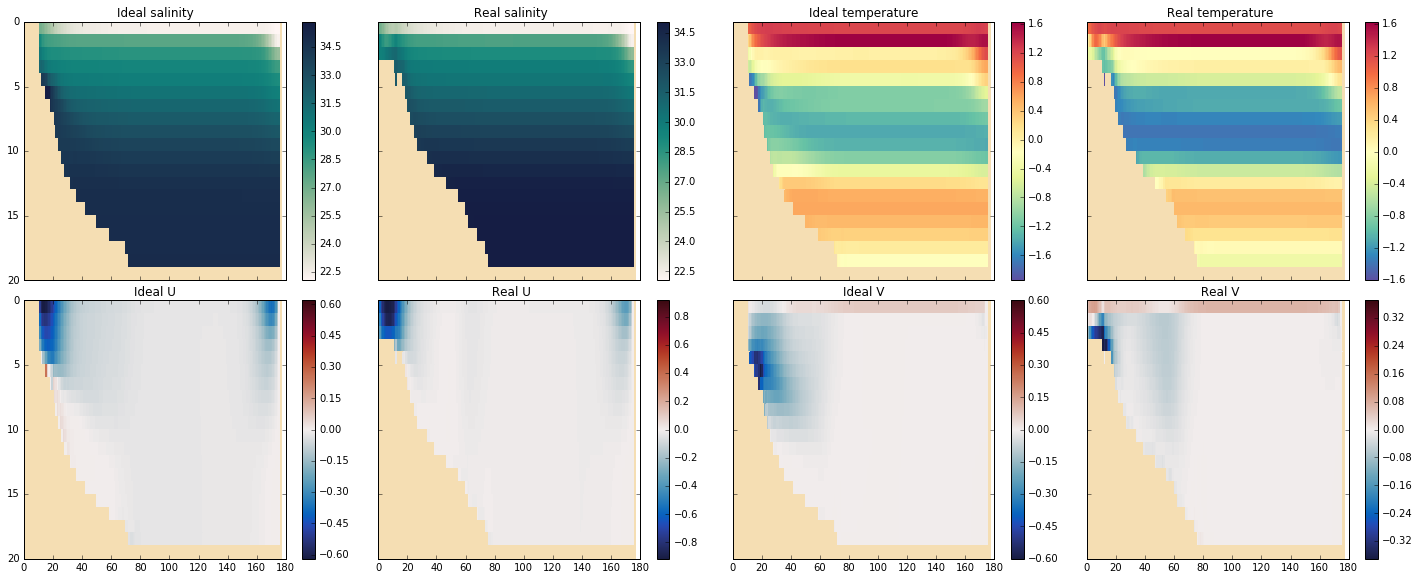

In [8]:
fig, [(ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)] = plt.subplots(2,4,figsize=(20, 8), sharey=True,sharex=True)
fig.tight_layout()
axesI = [ax1, ax3, ax5, ax7]; axesR = [ax2, ax4, ax6, ax8]
varbsI = [salI1, temI1, UI1, VI1]; varbsR = [salR1, temR1, UR1, VR1]
for axes, varbs, title, x in zip([axesI, axesR], [varbsI, varbsR], ['Ideal ',' Real '], [118, 143]):
    ttls = ['salinity', 'temperature', 'U', 'V']
    cmaps = [cmo.cm.tempo, cm.Spectral_r, cmo.cm.balance, cmo.cm.balance]
    for ax, var, cmap, ttl in zip(axes, varbs, cmaps, ttls):
        cmap.set_bad('wheat')
        this_var = var[18, :, :, x]
        if ttl == 'U' or ttl == 'V':
            cmin = this_var.min()
            c = ax.pcolormesh(this_var, cmap=cmap, vmin = cmin, vmax = -1*cmin)
        else:
            c = ax.pcolormesh(this_var, cmap=cmap)
        ax.set_ylim([20,0])
        ax.set_title(title+ttl)
        fig.colorbar(c, ax=ax)

# Calculating density

[Full documentation of gsw functions](http://www.teos-10.org/pubs/gsw/html/gsw_contents.html) and
[Salish Sea tools for calling gsw matlab functions](http://salishsea-meopar-tools.readthedocs.io/en/latest/_modules/salishsea_tools/gsw_calls.html#generic_gsw_caller)

The function **gsw_rho_CT_exact** uses the full Gibbs function, while gsw_rho uses the computationally efficient 75-term expression. It needs Absolute Salinity, Conservative Temperature for in situ density, and a reference pressure for potential density. The function **gsw_p_from_z** calculates sea pressure from height where height is negative in the ocean and from latitude.

[visualisations.py](https://bitbucket.org/salishsea/tools/src/0f9826250741b49e7bbfa294e94c52d7c5429232/SalishSeaTools/salishsea_tools/visualisations.py?at=default&fileviewer=file-view-default)

In [9]:
def gsw_pressure_arguments(coord_lats, depth_levels, y_transect):
    ''' The main purpose of this function is to reshape
    and tile the (20,) depth array and the (237,) coordinate
    slice so that they can both be (20,237) in order to find
    a (20,237) pressure field.
    '''
    depths = depth_levels.reshape(-1,1)
    depths_neg = depths * -1
    latitudes = coord_lats[y_transect,:]
    
    len_depths = len(depths)
    len_lats = len(latitudes)
    
    z = np.tile(depths_neg, (1, len_lats))
    lat = np.tile(latitudes, (len_depths, 1))
    return z, lat

In [10]:
def gsw_calculate_density(coord_lats, depth_levels, y_transect, time_ind, salx, temx, tmask):
    z, lat = gsw_pressure_arguments(coord_lats, depth_levels, y_transect)
    p = gsw_calls.generic_gsw_caller('gsw_p_from_z.m', [z,lat], matlab_gsw_dir='/ocean/rich/home/matlab/gsw3')

    SA = salx[time_ind, :, y_transect, :]
    CT = temx[time_ind, :, y_transect, :]

    rho = gsw_calls.generic_gsw_caller('gsw_rho_CT_exact.m', [SA,CT,p], matlab_gsw_dir='/ocean/rich/home/matlab/gsw3')
    
    tmask_rho = tmask[time_ind, : ,y_transect, :]   
    rho_masked = np.ma.array(rho, mask=tmask_rho)
        
    return rho_masked

In [11]:
time_ind = 18
y_transect = 40
bathyI_slice = bathyI[y_transect,:]
rho = gsw_calculate_density(coord_lats, depth_levels, y_transect, time_ind, salI1, temI1, tmaskI1)

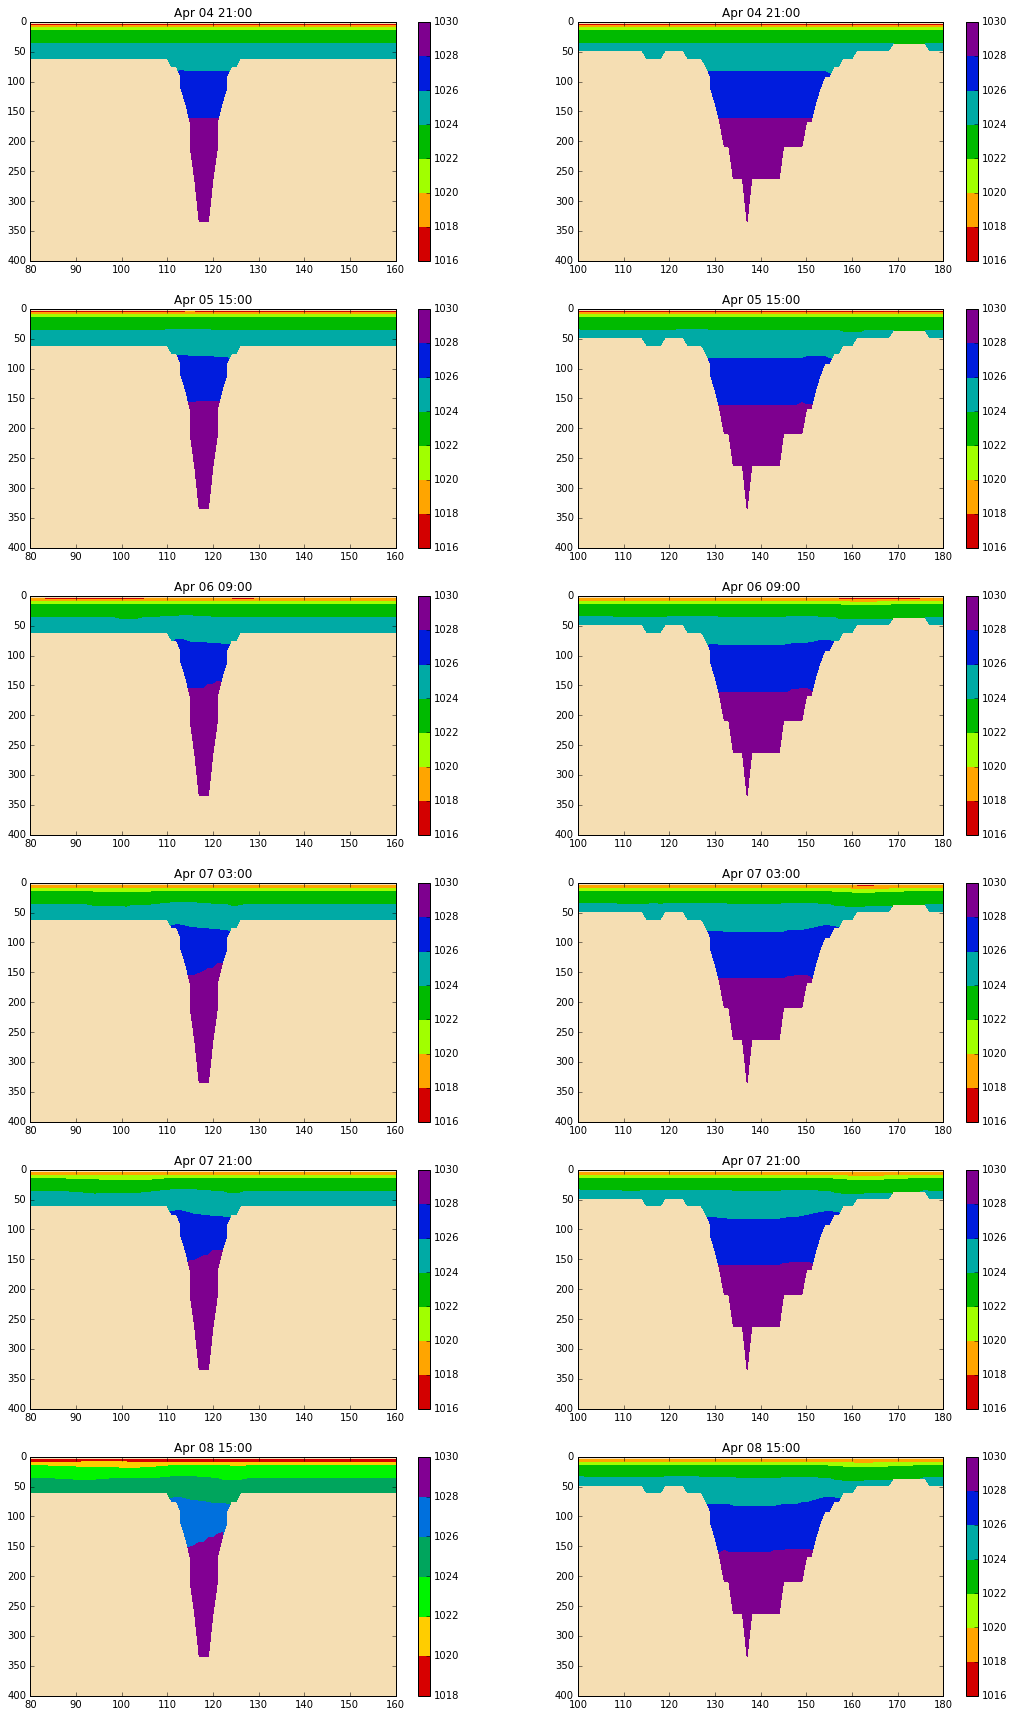

In [37]:
x_inds = np.arange(237)
levels = np.arange(1000,1051)[::2]

gridTs = [gridI1, gridR1]
sals = [salI1, salR1]
tems = [temI1, temR1]
tmasks = [tmaskI1, tmaskR1]
y_transects = [40, 50]
time_inds = [3, 6 , 9, 12, 15, 18]
xlims = [[80,160], [100,180]]

fig, ax = plt.subplots(len(time_inds), len(sals), figsize=(18, len(time_inds)*5))
cmap = cm.nipy_spectral_r
for gridT, sal, tem, tmask, xlim, y_transect, n in zip(gridTs, sals, tems, tmasks, xlims, y_transects, np.arange(len(sals))):
    for time_ind, i in zip(time_inds, np.arange(len(time_inds))):
        rho = gsw_calculate_density(coord_lats, depth_levels, y_transect, time_ind, sal, tem, tmask)
        c = ax[i,n].contourf(x_inds, depth_levels, rho, cmap = cmap)#colors='k', linewidths=1.5)
        ax[i,n].set_ylim([400,0])
        ax[i,n].set_xlim(xlim)
        timestamp = nc_tools.timestamp(gridT,time_ind).format('MMM DD HH:mm')
        ax[i,n].set_title(timestamp)
        fig.colorbar(c, ax=ax[i,n])
        ax[i,n].set_axis_bgcolor('wheat')

KeyError: 'variables'

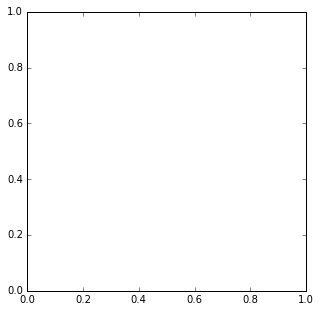

In [13]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
viz_tools.plot_land_mask(ax,bathyI,'grid', 400, None, None, 'wheat')

In [ ]:
import inspect
inspect.getsourcelines(viz_tools.plot_land_mask)